In [6]:
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL
from progressbar import ProgressBar
from numba_stats import norm_pdf
import numpy as np
import numba as nb
from matplotlib import pyplot as plt
from IPython.display import display

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3.065e+04                  │              Nfcn = 31               │
│ EDM = 9.53e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu_a │  -0.014   │   0.020   │            │            │         │         │       │
│ 1 │ mu_b │   1.013   │   0.020   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬─────────────────────┐
│      │      mu_a      mu_b │
├──────┼─────────────────────┤
│ mu_a │  0.000412 -0.000159 │
│ mu_b │ -0.000159   0.00041 │
└──────┴─────────────────────┘

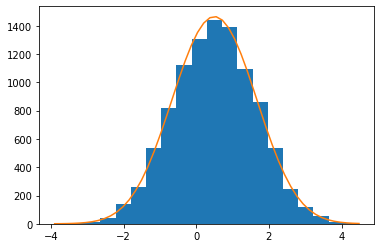

In [7]:
sigma = 1

def gen_data(rng, n):
    n0 = rng.binomial(n, 0.5)
    n1 = n - n0
    return np.append(rng.normal(0, sigma, size=n0), rng.normal(1, sigma, size=n1))

@nb.njit(nogil=True)
def model(x, mu_a, mu_b):
    return 0.5 * (norm_pdf(x, mu_a, sigma) + norm_pdf(x, mu_b, sigma))

rng = np.random.default_rng(0)

data = gen_data(rng, 10000)
m = Minuit(UnbinnedNLL(data, model), mu_a=0, mu_b=1)
display(m.migrad())
w, xe, _ = plt.hist(data, bins=20)
xm = np.linspace(np.min(data), np.max(data))
plt.plot(xm, model(xm, *m.values) * len(data) * (xe[1] - xe[0]));

In [8]:
def compute(n):
    n_try = 1000
    rng = np.random.default_rng(n)
    n_hesse = 0
    n_minos = 0
    h_pcov = []
    m_pcov = []
    cor = []
    n_fail = 0
    with ProgressBar() as bar:
        for i_try in bar(range(n_try)):
            for sub in range(5):
                data = gen_data(rng, n)
                nll = UnbinnedNLL(data, model)            
                m = Minuit(nll, mu_a=0, mu_b=1)
                m.migrad()
                m.hesse()
                m.minos()
                if m.valid and m.accurate:
                    break
                n_fail += 1
            mu = m.values["mu_a"]
            h_mu = m.errors["mu_a"]
            m_mu = m.merrors["mu_a"]
            cov = m.covariance
            c = cov[1,0] / np.sqrt(cov[0, 0] * cov[1, 1])
            if abs(mu) < h_mu:
                n_hesse += 1
            if (mu + m_mu.lower) < 0 < (mu + m_mu.upper):
                n_minos += 1
            cor.append(c)
        h_pcov.append(n_hesse / n_try)
        m_pcov.append(n_minos / n_try)
    print(f"{n} hesse {h_pcov[-1]:.2f} minos {m_pcov[-1]:.2f} <corr> {np.mean(cor):.3f} {n_fail=}", flush=True)
    return h_pcov, m_pcov, cor

if __name__ == "__main__":
    from concurrent.futures import ThreadPoolExecutor as Pool

    n_pts = (10, 20, 50, 70, 100, 200, 300, 400, 500, 1000, 2000, 3000)

    h_pcov = []
    m_pcov = []
    corr = []
    with Pool() as pool:
        for (h, m, c) in pool.map(compute, n_pts):
            h_pcov.append(h)
            m_pcov.append(m)
            corr.append(c)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:14 Time:  0:00:14
100% (1000 of 1000) |####################| Elapsed Time: 0:00:14 Time:  0:00:14

70 hesse 0.75 minos 0.67 <corr> -0.472 n_fail=0


100% (1000 of 1000) |####################| Elapsed Time: 0:00:16 Time:  0:00:16
100% (1000 of 1000) |####################| Elapsed Time: 0:00:16 Time:  0:00:16

50 hesse 0.75 minos 0.67 <corr> -0.458 n_fail=0


100% (1000 of 1000) |####################| Elapsed Time: 0:00:22 Time:  0:00:22
 44% (440 of 1000) |#########            | Elapsed Time: 0:00:22 ETA:   0:00:21

100 hesse 0.77 minos 0.69 <corr> -0.461 n_fail=0


100% (1000 of 1000) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
100% (1000 of 1000) |####################| Elapsed Time: 0:00:26 Time:  0:00:26

20 hesse 0.77 minos 0.73 <corr> -0.450 n_fail=0


100% (1000 of 1000) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
100% (1000 of 1000) |####################| Elapsed Time: 0:00:26 Time:  0:00:26

10 hesse 0.76 minos 0.75 <corr> -0.388 n_fail=7


100% (1000 of 1000) |####################| Elapsed Time: 0:00:33 Time:  0:00:33
100% (1000 of 1000) |####################| Elapsed Time: 0:00:33 Time:  0:00:33

1000 hesse 0.67 minos 0.67 <corr> -0.407 n_fail=0


100% (1000 of 1000) |####################| Elapsed Time: 0:00:34 Time:  0:00:34
100% (1000 of 1000) |####################| Elapsed Time: 0:00:34 Time:  0:00:34

500 hesse 0.70 minos 0.69 <corr> -0.413 n_fail=0


100% (1000 of 1000) |####################| Elapsed Time: 0:00:34 Time:  0:00:34
100% (1000 of 1000) |####################| Elapsed Time: 0:00:34 Time:  0:00:34

400 hesse 0.70 minos 0.69 <corr> -0.422 n_fail=0


100% (1000 of 1000) |####################| Elapsed Time: 0:00:35 Time:  0:00:35
100% (1000 of 1000) |####################| Elapsed Time: 0:00:35 Time:  0:00:35

2000 hesse 0.69 minos 0.69 <corr> -0.401 n_fail=0


100% (1000 of 1000) |####################| Elapsed Time: 0:00:35 Time:  0:00:35
100% (1000 of 1000) |####################| Elapsed Time: 0:00:35 Time:  0:00:35

300 hesse 0.68 minos 0.67 <corr> -0.420 n_fail=0


100% (1000 of 1000) |####################| Elapsed Time: 0:00:35 Time:  0:00:35
100% (1000 of 1000) |####################| Elapsed Time: 0:00:35 Time:  0:00:35

200 hesse 0.69 minos 0.66 <corr> -0.435 n_fail=0


100% (1000 of 1000) |####################| Elapsed Time: 0:00:35 Time:  0:00:35
100% (1000 of 1000) |####################| Elapsed Time: 0:00:35 Time:  0:00:35

3000 hesse 0.69 minos 0.69 <corr> -0.404 n_fail=0


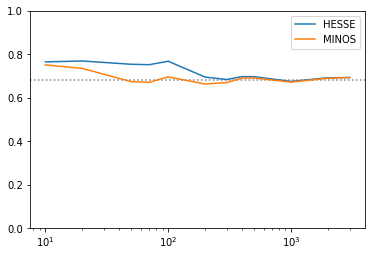

In [9]:
plt.plot(n_pts, h_pcov, label="HESSE")
plt.plot(n_pts, m_pcov, label="MINOS")
plt.axhline(0.68, ls=":", color="0.5", zorder=0)
plt.semilogx()
plt.legend()
plt.ylim(0, 1);